Source: https://theeffectbook.net/ch-DifferenceinDifference.html?panelset2=python-code3

Specifically we’ll be looking at a paper by Kessler and Roth (2014 Kessler, Judd B, and Alvin E Roth. 2014. “Don’t Take ’No’ for an Answer: An Experiment with Actual Organ Donor Registrations.” National Bureau of Economic Research.), which studies the rate at which people sign up to be organ donors.

In the United States, people are not signed up to be organ donors by default - it is _opt in_.

 <mark>July 2011, the state of California switched from opt-in to active choice</mark>. Kessler and Roth decided to compare California against the twenty-five states that either have opt-in or a verbally given question with no fixed response

In [ ]:
!pip install linearmodels --quiet
!pip install causaldata --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
import matplotlib as plt
import linearmodels as lm
from causaldata import organ_donations

In [ ]:
od = organ_donations.load_pandas().data

In [ ]:
# Create Treatment Variable
od['California'] = od['State'] == 'California'

In [ ]:
od.head(7)

,State,Quarter,Rate,Quarter_Num,California
0,Alaska,Q42010,0.7500,1,False
1,Alaska,Q12011,0.7700,2,False
2,Alaska,Q22011,0.7700,3,False
3,Alaska,Q32011,0.7800,4,False
4,Alaska,Q42011,0.7800,5,False
5,Alaska,Q12012,0.7900,6,False
6,Arizona,Q42010,0.2634,1,False


Create our interactions by hand,
<mark>skipping quarter 3, the last one before treatment:


In [ ]:
# Create our interactions by hand,
# skipping quarter 3, the last one before treatment
for i in [1, 2, 4, 5, 6]:  # <-- nb skipping "3"
    name = 'INX'+str(i)
    od[name] = 1*od['California']
    od.loc[od['Quarter_Num'] != i, name] = 0

In [ ]:
od.iloc[10:19,:]

,State,Quarter,Rate,Quarter_Num,California,INX1,INX2,INX4,INX5,INX6
10,Arizona,Q42011,0.2351,5,False,0,0,0,0,0
11,Arizona,Q12012,0.2587,6,False,0,0,0,0,0
12,California,Q42010,0.2666,1,True,1,0,0,0,0
13,California,Q12011,0.2731,2,True,0,1,0,0,0
14,California,Q22011,0.2743,3,True,0,0,0,0,0
15,California,Q32011,0.2636,4,True,0,0,1,0,0
16,California,Q42011,0.2607,5,True,0,0,0,1,0
17,California,Q12012,0.2641,6,True,0,0,0,0,1
18,Colorado,Q42010,0.6653,1,False,0,0,0,0,0


In [ ]:
# Set our individual and time (index) for our data
od = od.set_index(['State','Quarter_Num'])
od.head()

# Why?
#https://bashtage.github.io/linearmodels/panel/panel/linearmodels.panel.model.PanelOLS.from_formula.html
# Data structure that can be coerced into a PanelData. In most cases, this
# should be a multi-index DataFrame where the level 0 index contains the
# entities and the level 1 contains the time.



Quarter  Rate  California  INX1  INX2  INX4  INX5  INX6
State  Quarter_Num                                                        
Alaska 1            Q42010  0.75       False     0     0     0     0     0
       2            Q12011  0.77       False     0     0     0     0     0
       3            Q22011  0.77       False     0     0     0     0     0
       4            Q32011  0.78       False     0     0     0     0     0
       5            Q42011  0.78       False     0     0     0     0     0

In [ ]:
mod = lm.PanelOLS.from_formula('''Rate ~
INX1 + INX2 + INX4 + INX5 + INX6 +
EntityEffects + TimeEffects''',od)

# Specify clustering when we fit the model
clfe = mod.fit(cov_type = 'clustered',
cluster_entity = True)
# Clustered sandwich estimators are used to adjust inference
# when errors are correlated within (but not between) clusters

In [ ]:
clfe

Dep. Variable:,Rate,R-squared:,0.0098
Estimator:,PanelOLS,R-squared (Between):,-0.0009
No. Observations:,162,R-squared (Within):,-0.0021
Date:,"Mon, Sep 18 2023",R-squared (Overall):,-0.0009
Time:,19:28:11,Log-likelihood,388.62
Cov. Estimator:,Clustered,,
,,F-statistic:,0.2471
Entities:,27,P-value,0.9406
Avg Obs:,6.0000,Distribution:,"F(5,125)"
Min Obs:,6.0000,,
Max Obs:,6.0000,F-statistic (robust):,4.9490


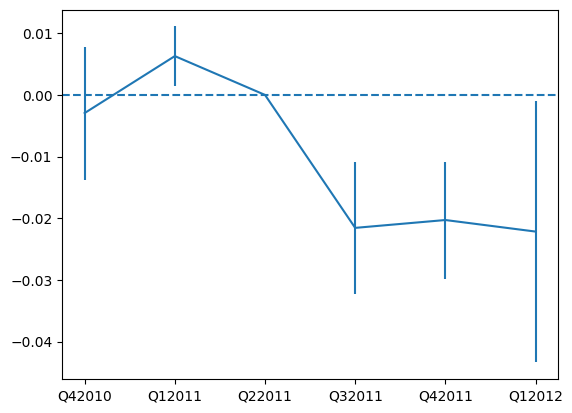

In [ ]:


# Get coefficients and CIs
res = pd.concat([clfe.params, clfe.std_errors], axis = 1)
# Scale standard error to CI
res['ci'] = res['std_error']*1.96

# Add our quarter values
res['Quarter_Num'] = [1, 2, 4, 5, 6]
# And add our reference period back in
reference = pd.DataFrame([[0,0,0,3]],
columns = ['parameter',
            'lower',
            'upper',
            'Quarter_Num'])
res = pd.concat([res, reference])

# For plotting, sort and add labels
res = res.sort_values('Quarter_Num')
res['Quarter'] = ['Q42010','Q12011',
                    'Q22011','Q32011',
                    'Q42011','Q12012']

# Plot the estimates as connected lines with error bars

plt.pyplot.errorbar(x = 'Quarter', y = 'parameter',
                    yerr = 'ci', data = res)
# Add a horizontal line at 0
plt.pyplot.axhline(0, linestyle = 'dashed')
